In [86]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import string
import emoji

import matplotlib.pyplot as plt
import seaborn as sns

In [93]:
# Charger le jeu de données à partir du fichier CSV
data = pd.read_csv('data/Emotion_final.csv')


In [12]:
data.head()

,text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


# Étudier la répartition des textes par émotions

In [13]:
emotion_counts = data['Emotion'].value_counts()
print("Répartition des textes par émotions :")
print(emotion_counts)

Répartition des textes par émotions :
Emotion
happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: count, dtype: int64


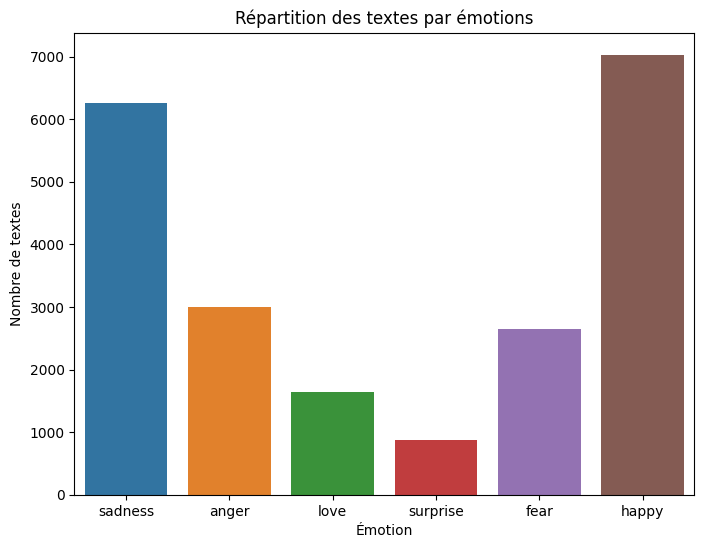

In [14]:
# Tracer un diagramme à barres pour visualiser la répartition des émotions
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Emotion')
plt.title("Répartition des textes par émotions")
plt.xlabel("Émotion")
plt.ylabel("Nombre de textes")
plt.show()

# Preprocessing

In [101]:
# Charger le jeu de données à partir du fichier CSV
data = pd.read_csv('data/Emotion_final.csv')

## Tokennisation

In [102]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/charles/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [103]:
data['tokens'] = data['text'].apply(word_tokenize)

## Gestion de la ponctuation

In [104]:
punctuations = list(string.punctuation)
data["tokens"]= data["tokens"].apply( lambda x: [word for word in x if word.lower() not in punctuations])

## Gestion des stopwords

In [105]:
# Télécharger les stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/charles/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [106]:
# Créer un ensemble de stopwords en français
stopwords_en = set(stopwords.words('english'))

custom_stopwords = [
     'feeling','like','im','know','really',
     'get','feel','want','would','way','one',
     'still','little','bit','ive'     
     ]
stop = list(stopwords_en) + custom_stopwords 

In [107]:
data["tokens"]= data["tokens"].apply( lambda x: [word for word in x if word.lower() not in stop])

## Lemmatization

In [108]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
data['tokens'] = data['tokens'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])


[nltk_data] Downloading package wordnet to /Users/charles/nltk_data...


# Analyse de la proximité entre les émotions

In [120]:
data.head()

,text,Emotion,tokens
0,i didnt feel humiliated,sadness,"[didnt, humiliated]"
1,i can go from feeling so hopeless to so damned...,sadness,"[go, hopeless, damned, hopeful, around, someon..."
2,im grabbing a minute to post i feel greedy wrong,anger,"[grabbing, minute, post, greedy, wrong]"
3,i am ever feeling nostalgic about the fireplac...,love,"[ever, nostalgic, fireplace, property]"
4,i am feeling grouchy,anger,[grouchy]


In [124]:
# Créer un dictionnaire de fréquences de mots pour chaque émotion
emotion_word_freqs = {}
for emotion in data['Emotion'].unique():
    texts = data[data['Emotion'] == emotion]['tokens']
    words = [word for text in texts for word in text]
    freq_dist = FreqDist(words)
    emotion_word_freqs[emotion] = freq_dist

In [113]:
# Identifiez les 30 mots les plus courants pour chaque sentiment en dehors des stopwords
top_words_by_emotion = {}
for emotion, freq_dist in emotion_word_freqs.items():
    top_words = [word for word, freq in freq_dist.most_common(30)]
    top_words_by_emotion[emotion] = top_words

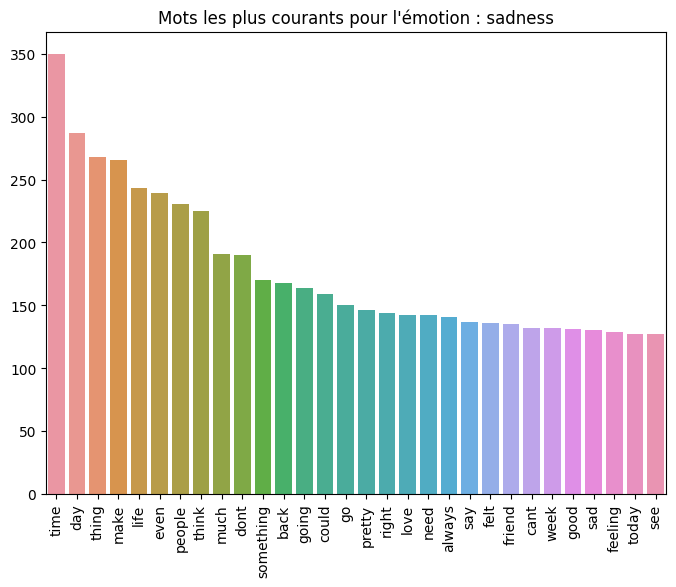

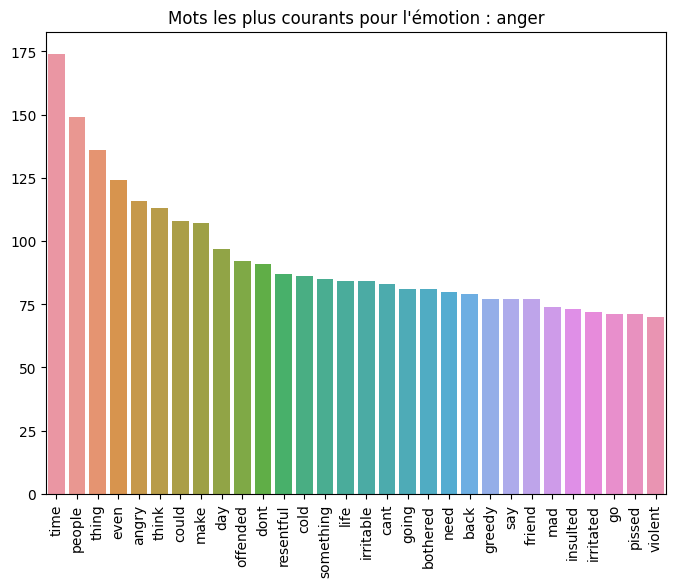

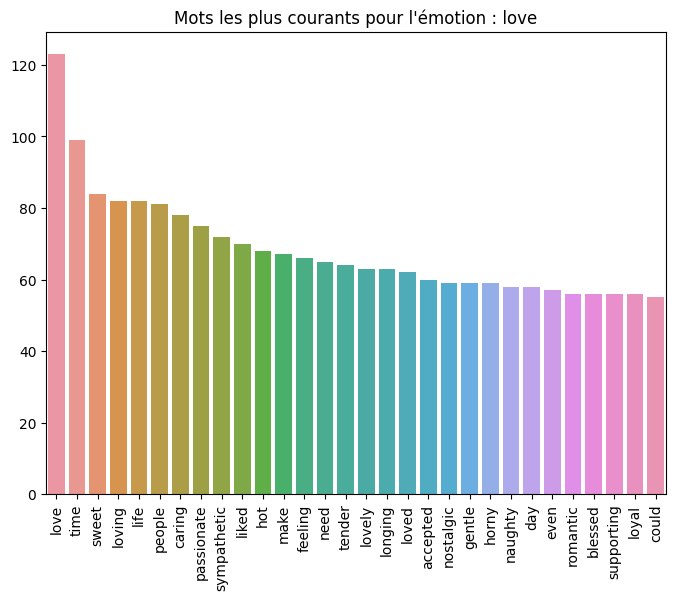

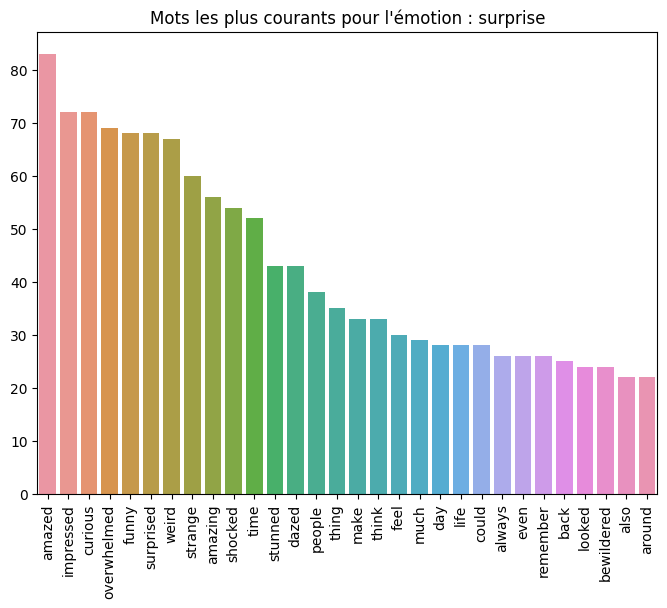

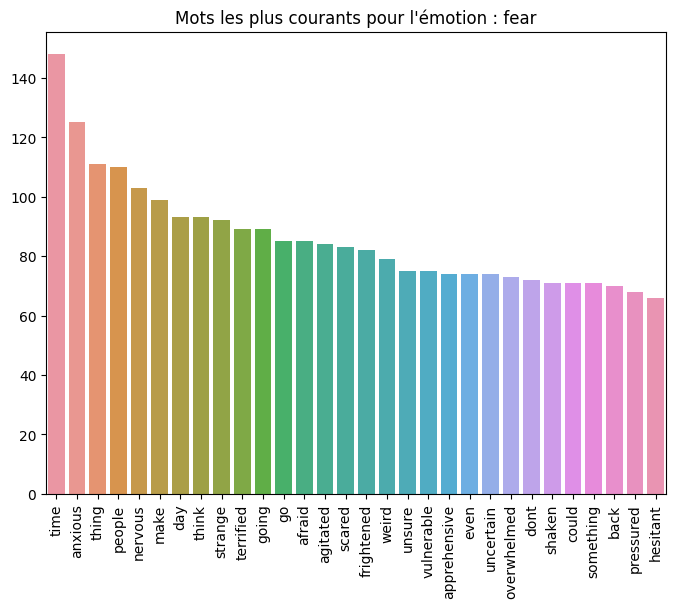

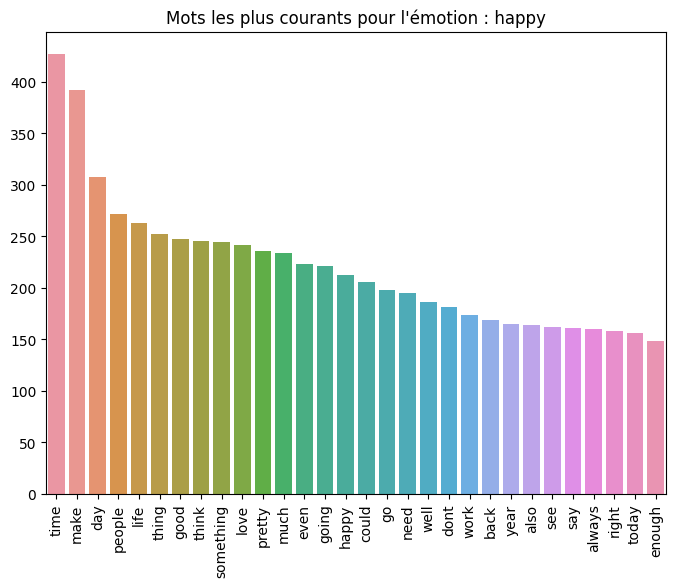

In [114]:
for emotion, top_words in top_words_by_emotion.items():
    word_freqs = [emotion_word_freqs[emotion][word] for word in top_words]
    plt.figure(figsize=(8, 6))
    sns.barplot(x=top_words, y=word_freqs)
    plt.title(f"Mots les plus courants pour l'émotion : {emotion}")
    plt.xticks(rotation=90)

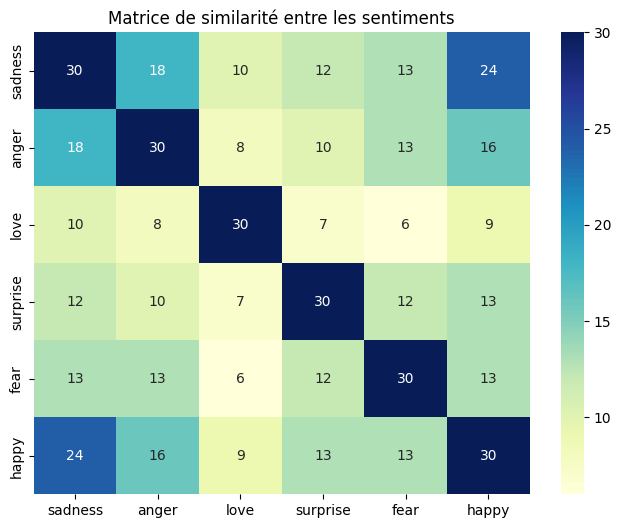

In [115]:
similarity_matrix = pd.DataFrame(0, index=data['Emotion'].unique(), columns=data['Emotion'].unique())
for emotion1 in data['Emotion'].unique():
    for emotion2 in data['Emotion'].unique():
        common_words = set(top_words_by_emotion[emotion1]).intersection(top_words_by_emotion[emotion2])
        similarity_matrix.loc[emotion1, emotion2] = len(common_words)

# Afficher la matrice de similarité sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, cmap="YlGnBu")
plt.title("Matrice de similarité entre les sentiments")
plt.show()

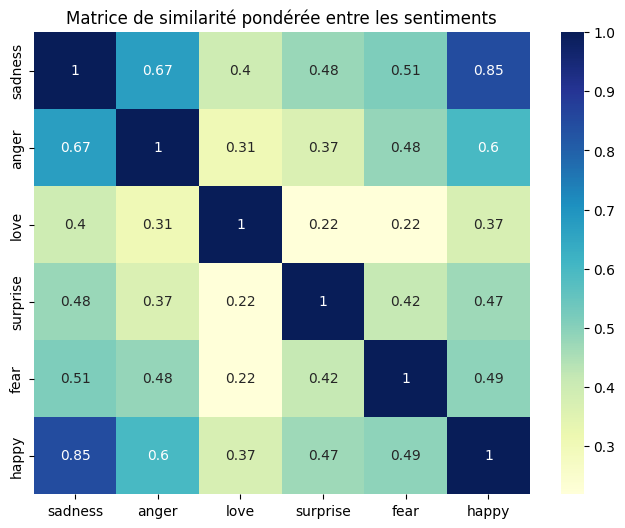

In [116]:
# Définir une métrique de proximité pondérée entre les sentiments basée sur les mots communs
weighted_similarity_matrix = pd.DataFrame(0, index=data['Emotion'].unique(), columns=data['Emotion'].unique())
for emotion1 in data['Emotion'].unique():
    for emotion2 in data['Emotion'].unique():
        common_words = set(top_words_by_emotion[emotion1]).intersection(top_words_by_emotion[emotion2])
        total_words_emotion1 = sum([emotion_word_freqs[emotion1][word] for word in top_words_by_emotion[emotion1]])
        total_words_emotion2 = sum([emotion_word_freqs[emotion2][word] for word in top_words_by_emotion[emotion2]])
        total_words = total_words_emotion1 + total_words_emotion2
        similarity = sum([emotion_word_freqs[emotion1][word] + emotion_word_freqs[emotion2][word] for word in common_words])/total_words
        weighted_similarity_matrix.loc[emotion1, emotion2] = similarity

# Afficher la matrice de similarité pondérée sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(weighted_similarity_matrix, annot=True, cmap="YlGnBu")
plt.title("Matrice de similarité pondérée entre les sentiments")
plt.show()

# Bag of words

In [118]:
# Create training and test sets
X = data['tokens'].apply(' '.join)
y = data['Emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create Bag of Words model
count_vectorizer = CountVectorizer()
X_train_bow = count_vectorizer.fit_transform(X_train)
X_test_bow = count_vectorizer.transform(X_test)

# Train and predict with Bag of Words model
model_bow = LogisticRegression()
model_bow.fit(X_train_bow, y_train)
y_pred_bow = model_bow.predict(X_test_bow)

# Calculate accuracy for Bag of Words model
accuracy_bow = accuracy_score(y_test, y_pred_bow)
print("Accuracy (Bag of Words):", accuracy_bow)

Accuracy (Bag of Words): 0.8960857409133272


/Users/charles/Documents/pythonProject/elasticsearch-nlp-sentiment_analysis/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# TF-IDF

In [119]:
# Create TF-IDF model
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train and predict with TF-IDF model
model_tfidf = LogisticRegression()
model_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = model_tfidf.predict(X_test_tfidf)

# Calculate accuracy for TF-IDF model
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
print("Accuracy (TF-IDF):", accuracy_tfidf)

Accuracy (TF-IDF): 0.875349487418453


/Users/charles/Documents/pythonProject/elasticsearch-nlp-sentiment_analysis/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
